In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [3]:
%load_ext autoreload
%autoreload

In [4]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from scipy.stats import randint as sp_randint

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *
import pickle
from datetime import datetime

/home/anaconda/envs/py373/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# Load the pre-split data

store = pd.HDFStore('/home/dissertation/data/dfs_abt_split.h5')
X_train = store['X_train']
X_test = store['X_test']
y_train = store['y_train']
y_test = store['y_test']
store.close()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

cat_col= ['gender', 'city', 'registered_via']

X_train.head()

(600803, 165) (600803,)
(257487, 165) (257487,)


,bd,registration_init_time,city,gender,registered_via,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),SUM(transactions.actual_amount_paid),SUM(transactions.transaction_date),SUM(transactions.membership_expire_date),...,DIFF(MAX(transactions.planned_daily_price)),DIFF(MAX(transactions.daily_price)),DIFF(STD(transactions.payment_plan_days)),DIFF(STD(transactions.plan_list_price)),DIFF(STD(transactions.actual_amount_paid)),DIFF(STD(transactions.transaction_date)),DIFF(STD(transactions.membership_expire_date)),DIFF(STD(transactions.price_difference)),DIFF(STD(transactions.planned_daily_price)),DIFF(STD(transactions.daily_price))
551174,28,20131223,5,male,3,180,298.00,894.00,120923653,120924153,...,1.67,1.67,0.00,76.94,0.00,3890.64,3353.08,55.25,2.56,0.00
403333,20,20131223,13,male,3,127,627.00,627.00,100812365,100812869,...,1.03,1.03,9.96,42.15,71.37,-1967.03,-2345.67,-20.98,1.41,2.33
594889,18,20131227,13,male,3,540,2682.00,2682.00,362862440,362881912,...,0.00,0.00,0.00,-29.22,0.00,-371.25,-554.29,-20.98,-0.97,0.00
100379,0,20140109,1,unknown,7,547,2384.00,2682.00,382888820,383039868,...,0.00,0.00,4.90,21.64,34.18,-2480.05,344.36,9.19,0.73,1.08
207602,35,20140125,13,female,7,720,2529.00,2956.00,483713706,483807163,...,0.00,0.00,0.00,44.20,19.09,-1495.13,-544.06,38.55,1.47,0.64


In [ ]:
# X_train.columns[0:25]

In [ ]:
# ## TEMP TEMP TEMP ##
# for col in X_train.head().filter(regex='daily').columns:
#     X_train.drop(col, axis=1, inplace=True)
#     X_test.drop(col, axis=1, inplace=True)

In [4]:
import sklearn 
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
## WHAT METRIC SHOULD BE OPTIMSED AS PART OF CV

In [5]:
RANDOM_STATE = 42 
CV_ITER = 5
SCORING_METRIC = 'recall'
BASE_NAME = "dfsbasic_" + str(CV_ITER) + "cv_" + SCORING_METRIC

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]
classifiers = [
    ('NB_' + BASE_NAME, GaussianNB(), {}, SCORING_METRIC),
    ('DT_' + BASE_NAME, DecisionTreeClassifier(random_state=RANDOM_STATE), {}, SCORING_METRIC),
    ('RF_' + BASE_NAME, RandomForestClassifier(random_state=RANDOM_STATE, n_jobs =-1), {}, SCORING_METRIC),
    ('LR_' + BASE_NAME, LogisticRegression(random_state=RANDOM_STATE, solver = 'liblinear'), {}, SCORING_METRIC),
    ('MLP_' + BASE_NAME, MLPClassifier(random_state=RANDOM_STATE), {}, SCORING_METRIC),
    ('XGB_' + BASE_NAME, xgb.XGBClassifier(random_state=RANDOM_STATE, objective="binary:logistic"), {}, SCORING_METRIC) 
]

In [6]:
all_metrics = pd.DataFrame()
all_results = list()

### Experiment 1.1 Baseline - Default Settings - No sampling

Model Build Iteration 0
PRE-SAMPLING: (600803, 165) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (600803, 165) (600803,) Counter({0: 544661, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via']
Categorical columns in dataset ['gender', 'city', 'registered_via']
X_train:  (600803, 188) (600803, 1)
X_test:  (257487, 188) (257487, 1)


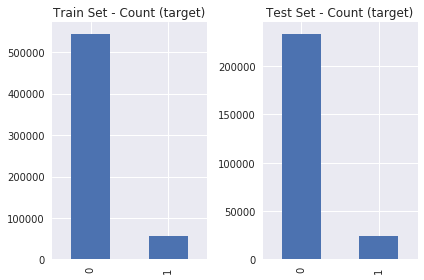

Training NB_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for NB_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training DT_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for DT_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training RF_dfsbasic_5cv_recall classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Generating test scores for RF_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training LR_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for LR_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training MLP_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for MLP_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Training XGB_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for XGB_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric


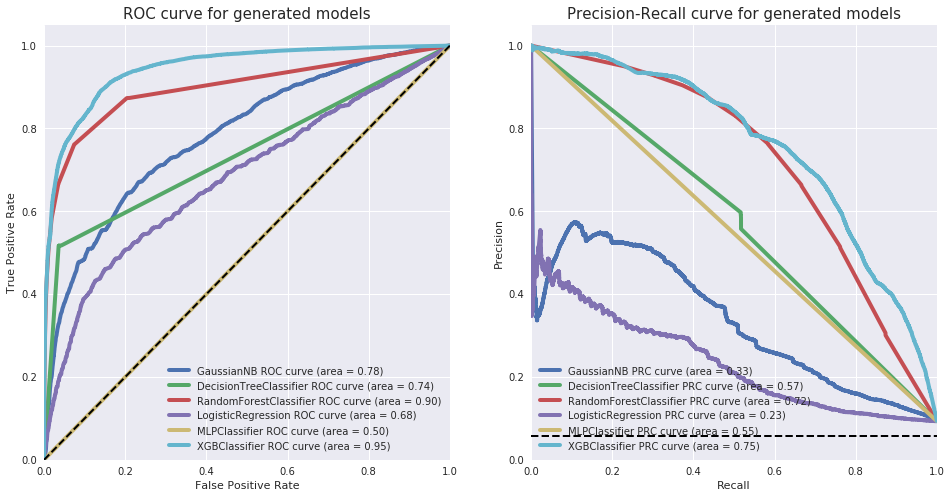

CPU times: user 1h 15min 53s, sys: 2min 2s, total: 1h 17min 55s
Wall time: 56min 1s


In [7]:
%%time
start = time.time()

sampler = ('None', DummySampler())

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("dfs, default_hyper, {0}, {1}".format(sampler[0], time.time()-start), 'DFS_DefaultHyper.log')

In [ ]:
all_metrics

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

Model Build Iteration 0
PRE-SAMPLING: (600803, 165) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (1089322, 165) (1089322,) Counter({1: 544661, 0: 544661})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via']
Categorical columns in dataset ['gender', 'city', 'registered_via']
X_train:  (1089322, 188) (1089322, 1)
X_test:  (257487, 188) (257487, 1)


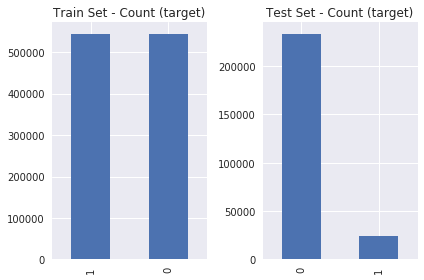

Training NB_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for NB_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training DT_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for DT_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training RF_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for RF_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training LR_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for LR_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training MLP_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for MLP_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training XGB_dfsba

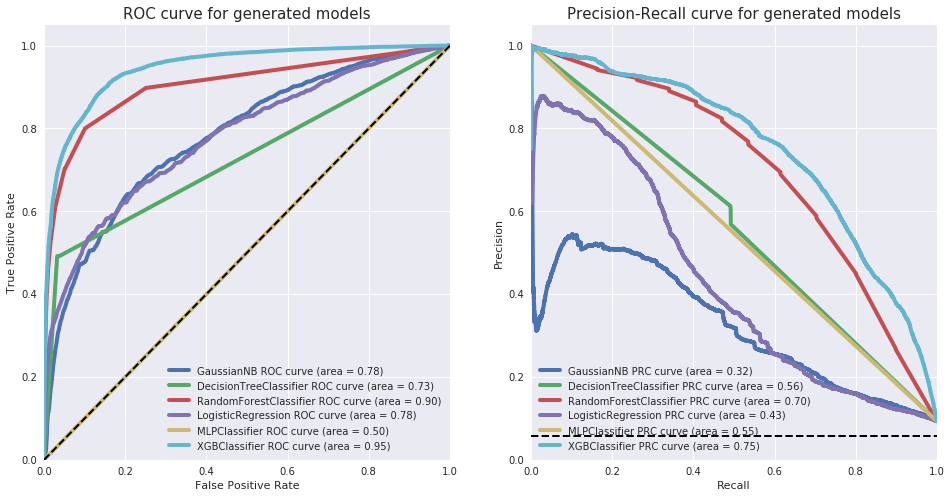

CPU times: user 3h 19min 16s, sys: 7min 56s, total: 3h 27min 12s
Wall time: 2h 19min 17s


In [8]:
%%time
start = time.time()

sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("dfs, default_hyper, {0}, {1}".format(sampler[0], time.time()-start), 'DFS_DefaultHyper.log')

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

Model Build Iteration 0
PRE-SAMPLING: (600803, 165) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (112284, 165) (112284,) Counter({0: 56142, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via']
Categorical columns in dataset ['gender', 'city', 'registered_via']
X_train:  (112284, 188) (112284, 1)
X_test:  (257487, 188) (257487, 1)


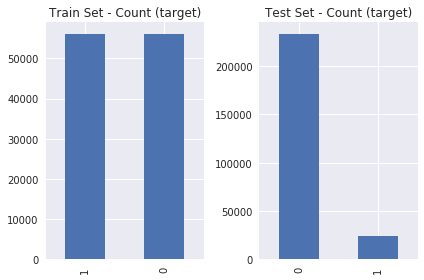

Training NB_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for NB_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training DT_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for DT_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training RF_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for RF_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training LR_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for LR_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training MLP_dfsbasic_5cv_recall classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Generating test scores for MLP_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training XGB_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for XGB_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric


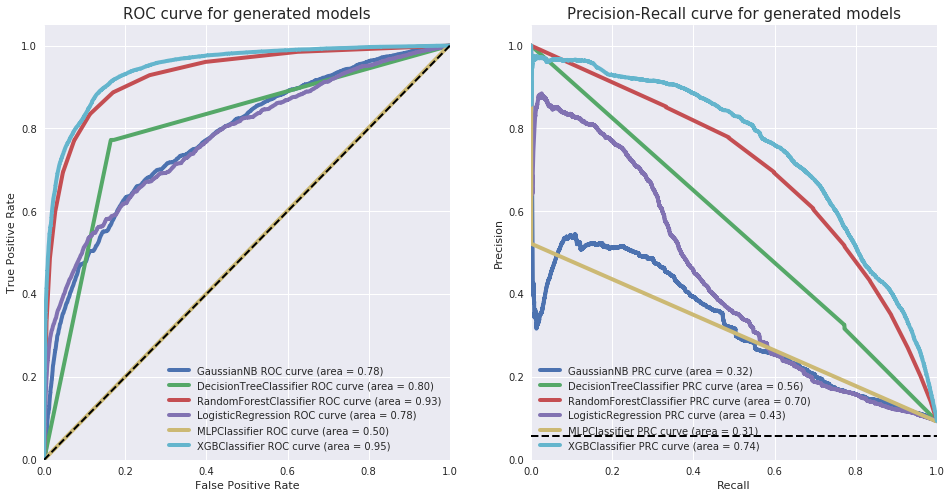

CPU times: user 47min 42s, sys: 1min 49s, total: 49min 32s
Wall time: 59min 58s


In [9]:
%%time
start = time.time()

sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("dfs, default_hyper, {0}, {1}".format(sampler[0], time.time()-start), 'DFS_DefaultHyper.log')

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("dfs, default_hyper, {0}, {1}".format(sampler[0], time.time()-start), 'DFS_DefaultHyper.log')

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("dfs, default_hyper, {0}, {1}".format(sampler[0], time.time()-start), 'DFS_DefaultHyper.log')

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("dfs, default_hyper, {0}, {1}".format(sampler[0], time.time()-start), 'DFS_DefaultHyper.log')

### Experiment 1.7 Baseline Default Settings SMOTE-NC

Model Build Iteration 0
PRE-SAMPLING: (600803, 165) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (1089322, 165) (1089322,) Counter({1: 544661, 0: 544661})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via']
Categorical columns in dataset ['gender', 'city', 'registered_via']
X_train:  (1089322, 188) (1089322, 1)
X_test:  (257487, 188) (257487, 1)


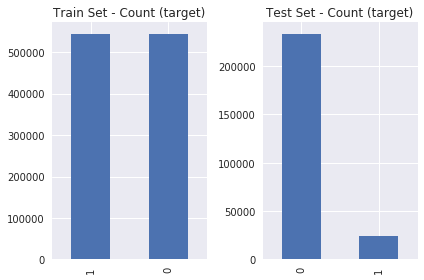

Training NB_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for NB_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training DT_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for DT_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training RF_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for RF_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training LR_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for LR_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training MLP_dfsbasic_5cv_recall classifier
No params set, using Standard training
Generating test scores for MLP_dfsbasic_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training XGB_dfsba

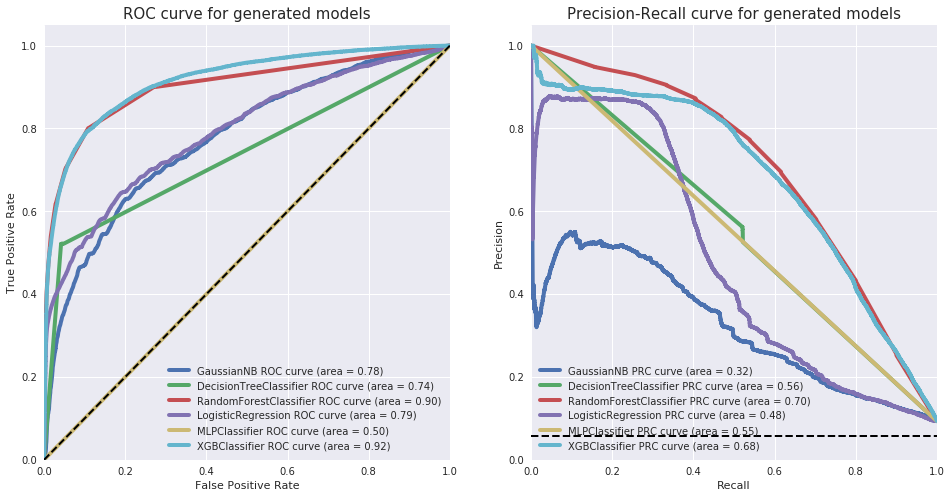

CPU times: user 5h 59min 54s, sys: 16min 26s, total: 6h 16min 20s
Wall time: 3h 21min 7s


In [10]:
%%time
start = time.time()

sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,8,13,14], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'gender', 'age_cat', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times','transaction_date_delta']

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("dfs, default_hyper, {0}, {1}".format(sampler[0], time.time()-start), 'DFS_DefaultHyper.log')

In [13]:
all_results

[('None_dfsbasic_5cv_recall',
                       label              classifier sampling_method      tn  \
  0   NB_dfsbasic_5cv_recall              GaussianNB            None  231265   
  0   DT_dfsbasic_5cv_recall  DecisionTreeClassifier            None  225049   
  0   RF_dfsbasic_5cv_recall  RandomForestClassifier            None  231892   
  0   LR_dfsbasic_5cv_recall      LogisticRegression            None  233426   
  0  MLP_dfsbasic_5cv_recall           MLPClassifier            None  233426   
  0  XGB_dfsbasic_5cv_recall           XGBClassifier            None  232058   
  
        fn     tp    fp  accuracy  precision  recall  ...  log_loss  train_time  \
  0  21233   2828  2161      0.91       0.57    0.12  ...      3.14       14.97   
  0  11630  12431  8377      0.92       0.60    0.52  ...      2.68      117.74   
  0  13527  10534  1534      0.94       0.87    0.44  ...      2.02       32.27   
  0  24060      1     0      0.91       1.00    0.00  ...      3.23       1

### Persist results to disk

In [15]:
'DFS_Default_{0}.pickle'.format(datetime.today().strftime('%Y-%m-%d'))

'DFS_Default_2019-08-04.pickle'

In [16]:
# Write (overwrite) the file to store the experiment results
with open('DFS_Default_2019-08-04.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    print("Writing results to", f.name)
    pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

Writing results to DFS_Default_2019-08-04.pickle


### Sort the results and get the best sampling config per classifier 

In [17]:
top_results = all_metrics.sort_values(['balanced_accuracy'], ascending=[False]).groupby('classifier').head(1)
top_results

,label,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,...,log_loss,train_time,cv_time,aucroc,auprc,balanced_accuracy,cv_score_mean,cv_score_std,model_churn_cost,sample
0,XGB_dfsbasic_5cv_recall,XGBClassifier,ROS 1:1,217765,5172,18889,15661,0.92,0.55,0.79,...,2.79,675.14,163.02,0.95,0.75,0.86,0.65,0.04,6041000,0
0,RF_dfsbasic_5cv_recall,RandomForestClassifier,RUS 1:1,215849,5468,18593,17577,0.91,0.51,0.77,...,3.09,8.19,22.48,0.93,0.70,0.85,0.62,0.02,6351000,0
0,DT_dfsbasic_5cv_recall,DecisionTreeClassifier,RUS 1:1,194895,5488,18573,38531,0.83,0.33,0.77,...,5.90,18.29,50.01,0.80,0.56,0.80,0.66,0.02,8454400,0
0,LR_dfsbasic_5cv_recall,LogisticRegression,SMOTE_NC,178987,7755,16306,54439,0.76,0.23,0.68,...,8.34,65.30,11.35,0.79,0.48,0.72,0.00,0.00,10952000,0
0,NB_dfsbasic_5cv_recall,GaussianNB,SMOTE_NC,227221,17831,6230,6205,0.91,0.50,0.26,...,3.22,21.73,7.89,0.78,0.32,0.62,0.12,0.01,10159000,0
0,MLP_dfsbasic_5cv_recall,MLPClassifier,RUS 1:1,233415,24049,12,11,0.91,0.52,0.00,...,3.23,1410.72,1748.23,0.50,0.31,0.50,-1.00,-1.00,12026800,0


### Graph the results base on the list of best classifiers above

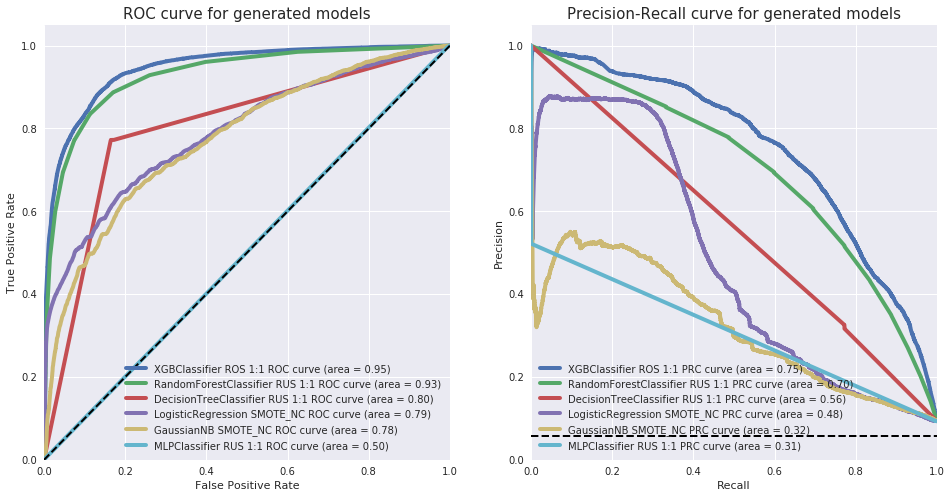

In [18]:
temp = filter_top_model_results(top_results, all_results)
plot_roc_prc(temp)

In [20]:
all_metrics.sampling_method.unique()

array(['None', 'ROS 1:1', 'RUS 1:1', 'SMOTE_NC'], dtype=object)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)